In [1]:
from Functions import *
from tqdm import tqdm

In [2]:
''' Beam parameters '''
N = 4096			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 10000		# total simulation time window [fs]

''' OE parameters '''
hkl = [4,4,0]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 630
}

f1_list = np.linspace(-.05,.05,100)+9.541380371243974
if_plot = 1
if_loop = 1
duration = np.zeros_like(f1_list)

In [3]:
def define_devices(
    f1, f2, slit_width = 1e-3, hkl = [1,1,1], alphaAsym = 0., E0=18e3, f0 = 290., d23=7.):

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=5e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2,
                              E0=E0,alphaAsym=alphaAsym, orientation=2,pol='s', delta=0e-6)
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # CRL set 1, 1D focusing in horizontal
    crl1_1 = optics.CRL('crl1_1', z=crystal2.z+f1-.02, E0=E0, roc=200e-6,  diameter=5e-3)
    crl1_2 = optics.CRL('crl1_2', z=crystal2.z+f1-.01, E0=E0, roc=300e-6,  diameter=5e-3)
    crl1_3 = optics.CRL('crl1_3', z=crystal2.z+f1,     E0=E0, roc=300e-6,  diameter=5e-3)
    crl1_4 = optics.CRL('crl1_4', z=crystal2.z+f1+.01, E0=E0, roc=1000e-6, diameter=5e-3)
    crl1_5 = optics.CRL('crl1_5', z=crystal2.z+f1+.02, E0=E0, roc=5000e-6, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=crl1_3.z+.1,N=256,FOV=5e-3)

    # slit at focus
    slit = optics.Slit('slit', z=crl1_3.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1_3.z+f2 + 1e-3, FOV=5e-3, N=256)

    # CRL set 2, for collimation
    crl2_1 = optics.CRL('crl2_1', z=crl1_3.z+2*f2-.02, E0=E0, roc=200e-6,  diameter=5e-3)
    crl2_2 = optics.CRL('crl2_2', z=crl1_3.z+2*f2-.01, E0=E0, roc=300e-6,  diameter=5e-3)
    crl2_3 = optics.CRL('crl2_3', z=crl1_3.z+2*f2,     E0=E0, roc=300e-6,  diameter=5e-3)
    crl2_4 = optics.CRL('crl2_4', z=crl1_3.z+2*f2+.01, E0=E0, roc=1000e-6, diameter=5e-3)
    crl2_5 = optics.CRL('crl2_5', z=crl1_3.z+2*f2+.02, E0=E0, roc=5000e-6, diameter=5e-3)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2_3.z+d23, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2_3.z+d23 + (9.541380371243974-d23)*np.cos(crystal1.beta0*2),
                              E0=E0,alphaAsym=-alphaAsym, asym_type='emergence', orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=5e-3, N=256)

    # list of devices to propagate through
    devices = [im0, crl0, crystal1, crystal2, im_upstream,
               crl1_1, crl1_2, crl1_3, crl1_4, crl1_5, im1,
               slit,focus,
               crl2_1, crl2_2, crl2_3, crl2_4, crl2_5,
               crystal3,crystal4,im2]

    return devices

In [4]:
''' Define beamline '''
try: alphaAsym
except:
    crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                                  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)

    if alphaAsym <= 0:
        print('\n***\n***\n*** Bragg angle smaller than grazing angle')

f1 = f1_list.mean()
f2 = 10.

devices = define_devices(f1,f2,slit_width = 2000e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)

b 1.00
b 1.00
b 11.28
crystal 2 incidence angle: 80.86 degrees
crystal 2 exit angle: 5.02 degrees
b 1.00
b 0.09


In [5]:
%%capture capt
''' propagate '''
mono_beamline = beamline.Beamline(devices)

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

screen_names = ['im1','focus','im2']
part_names = ['1.after_crl1','2.focus','3.output']
pulse.propagate(beamline=mono_beamline, screen_names=screen_names)
tfin = time.time()

In [7]:
''' IO '''
path = '../Alignment_Results/'
make_dir(path)

case_path = path+'{} eV/'.format(E0)
make_dir(case_path)

if if_plot == 1:
    fig_path = case_path+'1st_crl_scan/'
    make_dir(fig_path)
    for file in os.listdir(fig_path):
        os.remove(fig_path+file)


hkl_ = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'pulse_duration_{}_{}keV_1st_crl'.format(
    hkl_, round(beam_params['photonEnergy']/1000.,4))


path exists
path exists
make path


In [8]:
print('propagation lasted {}s'.format(round(np.round(tfin-tstart),2)))

propagation lasted 12.0s


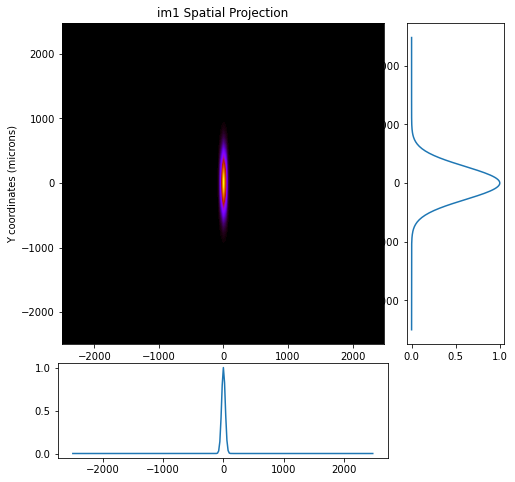

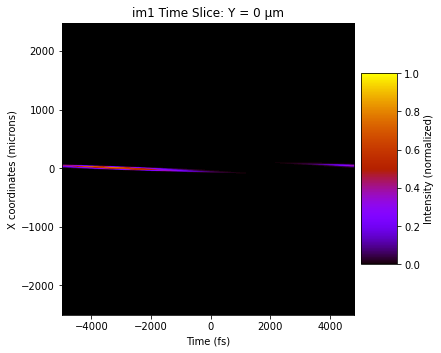

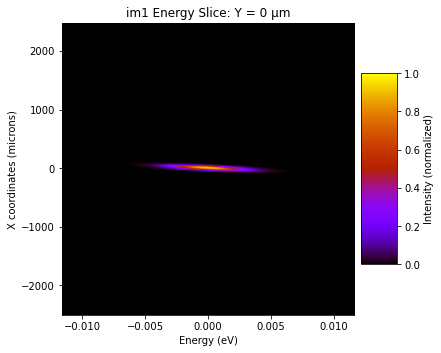

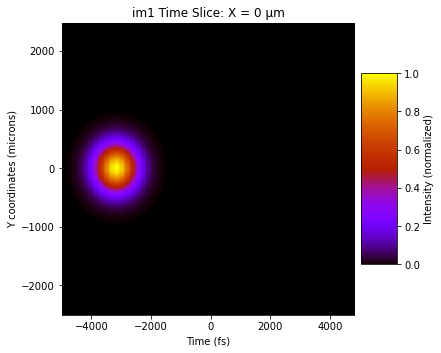

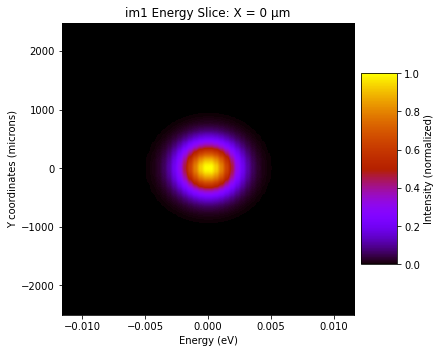

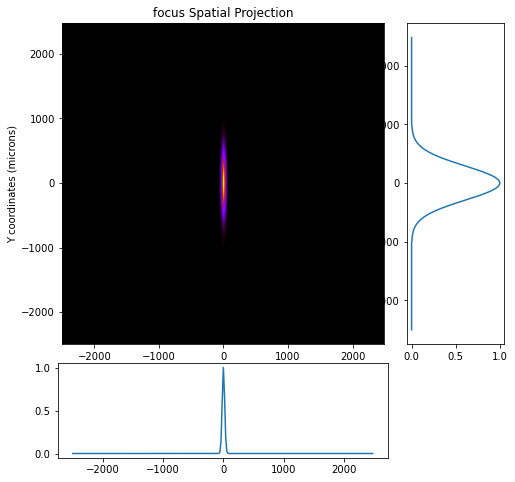

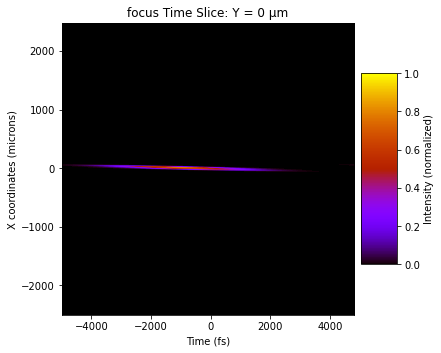

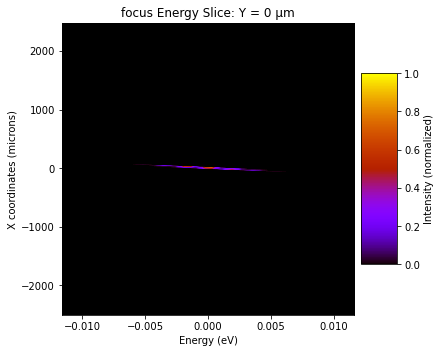

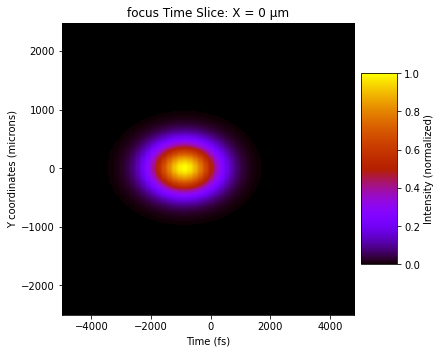

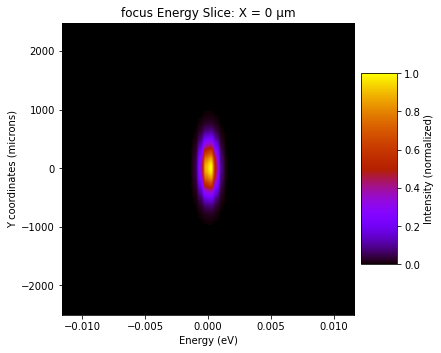

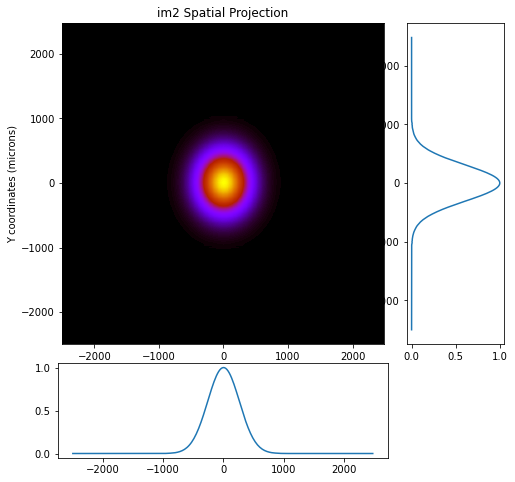

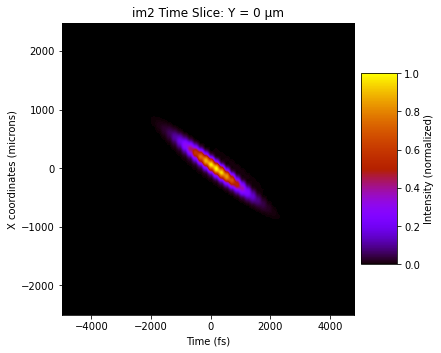

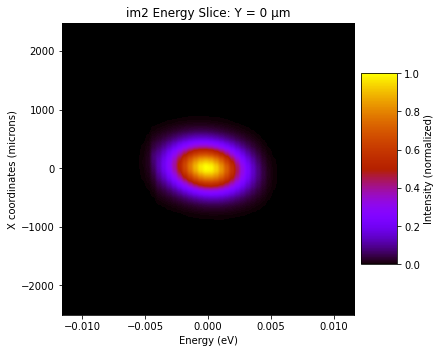

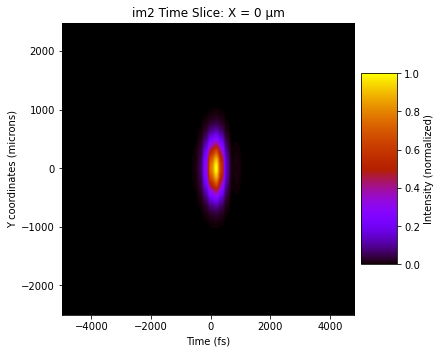

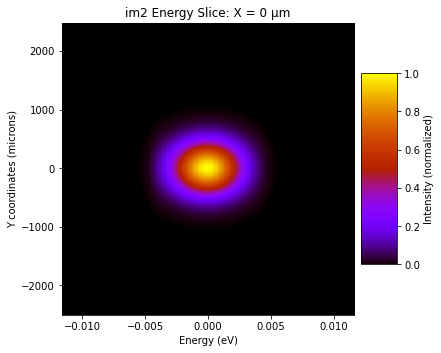

In [9]:
''' beam profiles '''
for i in range(len(screen_names)):
    im_name = screen_names[i]
    part_name = part_names[i]
    
    # spatial projection (xy)
    pulse.imshow_projection(im_name)
    # time and energy component slice (x/y vs t/E)
    for dim in ['x','y']:
        pulse.imshow_time_slice(im_name, dim=dim)
        pulse.imshow_energy_slice(im_name, dim=dim)

In [10]:
%%capture capt
for i, f1 in tqdm(enumerate(f1_list)):
    if if_plot + if_loop > 0:
        devices = define_devices(f1,f2,slit_width = 2000e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)
        mono_beamline = beamline.Beamline(devices)
        beam_params['photonEnergy'] = E0

        pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
        pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
        centroid, duration[i] = pulse.pulse_duration('im2')
    
    ''' ball park plots '''
    if if_plot == 1:
        
        pulse.imshow_time_slice('im2')
        fig_name = fig_path+'/{}_time_profile_f1={}_{}fs.png'.format(i, round(f1,5), round(duration[i],2))
        plt.savefig(fig_name)
        plt.close('all')
        
    ''' optimization '''
    if if_loop == 1:
        with h5py.File(case_path+fname+'.h5','w') as f:
            f.create_dataset('f1', data=f1_list)
            f.create_dataset('duration', data=duration)

f1_opt = f1_list[np.argmin(duration)]

9.539865219728823

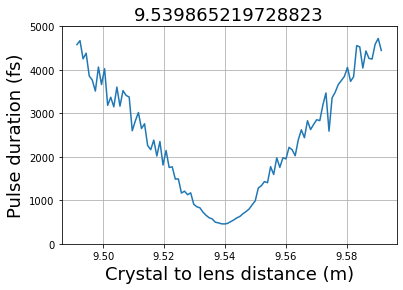

In [13]:
if os.path.exists(case_path+fname+'.h5'):
    with h5py.File(case_path+fname+'.h5','r') as f:
        f1_list = f['f1'][:]
        duration = f['duration'][:]

    f1_min = f1_list.min()
    #f1_min = 9.7
    f1_max = f1_list.max()
    ii = np.argwhere(f1_list>=f1_min).min()
    ifin = np.argwhere(f1_list<=f1_max).max()+1

    plt.figure()
    plt.plot(f1_list[ii:ifin], np.abs(duration[ii:ifin]))
    plt.xlabel('Crystal to lens distance (m)', fontsize=18)
    plt.ylabel('Pulse duration (fs)', fontsize=18)
    plt.ylim(0,5000)
    plt.grid()
    f1_opt = f1_list[ii:ifin][np.argmin(duration[ii:ifin])]
    plt.title(f1_opt, fontsize=18)
    plt.savefig(case_path+fname+'_{}-{}m.png'.format(round(f1_min,2), round(f1_max,2)))
f1_opt

In [12]:
import winsound
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)